<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b>
    Before proceeding, install or update your
    <b><a class="divlink" href="https://stenv.readthedocs.io/en/latest/">
    stenv
    </a></b>
    distribution. <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

# SBC Dark Analysis


## Introduction
***

This notebook has been prepared as a demo on how to perform aperture photometry in SBC images that contain an elevated dark rate. This problem arises when the detector temperature goes above ~25 ºC. 

More information on the dark rate can be found in [ISR ACS 2017-04](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr1704.pdf) (Avila 2017).

### This tutorial will show you how to...

#### 1. [Identify Images with Significant Dark Current](#_identify) 

* Open files and extract information
* Organize information in a table
* Sort table by temperature

#### 2. [Combine Science Images](#_scidrizzle)

* Use `AstroDrizzle` with ASN files to combine images.

#### 3. [Combined Dark Images](#_drkdrizzle)

* Identify which dark images to use for your data.
* Use `AstroDrizzle` to combine dark images.

#### 4. [Perform Photometry](#_photometry)

* Subtract dark current from science images using aperture photometry

## Imports
***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`matplotlib`      |`pyplot`    | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html">link</a>| plotting |
|`matplotlib`      |`colors.LogNorm`    | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.colors.LogNorm.html#matplotlib.colors.LogNorm">link</a>| data normalization used for contrast plotting |
|`matplotlib`      |`patches.Rectangle`   | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html">link</a>| add rectangle patch to plot |
|`numpy`           | `_s`               | <a class="divlink" href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.s_.html">link</a>| construct array slice object |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`drizzlepac`      |`astrodrizzle`      | <a class="divlink" href="https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html">link</a>| drizzle combine images |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format |
|`astropy.wcs`     | `WCS`              | <a class="divlink" href="http://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS">link</a>| extract WCS information from header |
|`photutils`       |`EllipticalAperture`| <a class="divlink" href="https://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html">link</a>| construct aperture object for plotting
|`photutils`       |`aperture_photometry`| <a class="divlink" href="https://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry">link</a>| extract counts from aperture

In [1]:
import os
import shutil
import glob

import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

from astropy.io import fits
from astropy.table import Table


from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

from photutils import EllipticalAperture
from photutils import aperture_photometry



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Download the Data
***

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

Using the python package `astroquery`, we can retreive files from the [MAST](http://archive.stsci.edu) archive.

#### [GO Proposal 13655](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=13655): "How Lyman alpha bites/beats the dust"

First, we will grab the FLT and ASN files from program 13655. For this example, we only want to retreive the files from visit 11 of this program. We will specify program ID 'JCMC' along with observation set ID '11'.

<div class="alert alert-danger">
<b>MAY CHANGE:</b> The argument "mrp_only" stands for "minimum recommended products only". It currently needs to be set to False, although in the future, False is intended to be set as the default and can be left out.
</div>

In [2]:
science_list = Observations.query_criteria(proposal_id='13655', obs_id='JCMC11*')

sci_dl_table = Observations.download_products(science_list['obsid'], 
                                              productSubGroupDescription=['ASN', 'FLT'],
                                              mrp_only=False)

#### [GO Proposal 13961](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=13961): "SBC Dark Current Measurement"

Now we need a set of dark calibration images. You can use any calibration set as long as the dark rate in the image matches that of your science image (discussed later in this notebook). For convenience, here we download the RAW dark frames from one calibration program: GO Proposal 13961.

In [3]:
darks_list = Observations.query_criteria(proposal_id='13961', obstype='cal')

drk_dl_table = Observations.download_products(darks_list['obsid'],
                                              productSubGroupDescription=['RAW'],
                                              mrp_only=False)

We'll use the packages `os` and `shutil` to put all of these files in our working directory for convenience and do a little housekeeping. Now let's place those images in the same directory as this notebook...

In [4]:
for dl_table in [sci_dl_table, drk_dl_table]:
    
    for row in dl_table:
        oldfname = row['Local Path']
        newfname = os.path.basename(oldfname)
        os.rename(oldfname, newfname)

shutil.rmtree('mastDownload/')

Below we define our filenames with variables for convenience using `glob.glob`.

In [5]:
asn_list = glob.glob('*_asn.fits')
flt_list = glob.glob('*_flt.fits')
drk_list = glob.glob('*_raw.fits')

## File Information

***

The structure of the fits files from ACS may be different depending on what kind of observation was made. For more information, refer to Section 2.2 of the [ACS Data Handbook](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

### Association Files

Association files only contain one extension which lists associated files and their types.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| ASN (Association)| (BinTableHDU)| Table of files associated with this group.             |

### Raw Files

A standard raw image file from the SBC has the same structure as you'd expect from full frame observation from ACS.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | Raw image data.                                        |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | Error array.                                           |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | Data quality array.                                    |

### FLT Files

SBC flat-fielded files have the same structure as the raw files, with additional HDUs for WCS corrections.

| Ext      | Name             | Type         | Contains                                               |
|----------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>  | PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>  | SCI (Image)      | (ImageHDU)   | Raw image data.                                        |
|<b>2</b>  | ERR (Error)      | (ImageHDU)   | Error array.                                           |
|<b>3</b>  | DQ (Data Quality)| (ImageHDU)   | Data quality array.                                    |
|<b>4-5</b>| WCSDVARR (WCS)   | (ImageHDU)   | Filter-dependent non-polynomial distortion corrections.|
|<b>6</b>  | WCSCORR (WCS)    | (BinTableHDU)| History of changes to the WCS solution.                |

You can always use `.info()` on an HDUlist for an overview of the structure.

In [6]:
with fits.open(drk_list[0]) as hdulist:
    hdulist.info()

Filename: jcrx01ijq_raw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     173   ()      
  1  SCI           1 ImageHDU        85   (1024, 1024)   int16   
  2  ERR           1 ImageHDU        49   ()      
  3  DQ            1 ImageHDU        43   ()      


## Identify Affected Observations <a id="_identify"></a>

***

Let's take a look at some information from our science images. We want to find observations with an average temperature greater than 25$^o$C. We can organize the information in a `Table` object from `astropy.table` for convenience. Here, we define a table with column names and respective data types.

<b>Note:</b> The FITS header keywords `mdecodt1` and `mdecodt2` refer to the temperature at the beginning and end of the exposure respectively.

In [7]:
flt_table = Table(names=('file', 'start', 'filter1', 'mdecodt1', 'mdecodt2', 'avgtemp'),
                  dtype=('S64', 'S19', 'S6', 'f8', 'f8', 'f8'))

Now we need to obtain information from the headers. The temperatures are stored in the science extensions, while observation information is found in the primary header.

<div class="alert alert-block alert-info"><b>Pro-Tip</b>: Adding rows to a table is a slow way to construct a table. For larger sets of data, consider
<a class="divlink" href="http://docs.astropy.org/en/stable/table/construct_table.html#empty-array-of-a-known-size">
    constructing a table of known size.
</a> </div>

In [8]:
for file in flt_list:
    filt = fits.getval(file, 'FILTER1', ext=0)
    date = fits.getval(file, 'DATE-OBS', ext=0)
    time = fits.getval(file, 'TIME-OBS', ext=0)
    
    t1 = fits.getval(file, 'MDECODT1', ext=1)
    t2 = fits.getval(file, 'MDECODT2', ext=1)

    starttime = date + 'T' + time
    avgtemp = (t1+t2) / 2
        
    flt_table.add_row((file, starttime, filt, t1, t2, avgtemp))

print(flt_table)

                     file                     ...      avgtemp      
--------------------------------------------- ... ------------------
                           jcmc11cwq_flt.fits ...            18.6693
hst_13655_11_acs_sbc_f165lp_jcmc11e6_flt.fits ...            25.9953
                           jcmc11ctq_flt.fits ...            17.3262
hst_13655_11_acs_sbc_f140lp_jcmc11cx_flt.fits ...             19.524
hst_13655_11_acs_sbc_f140lp_jcmc11ds_flt.fits ...            23.7975
                           jcmc11dsq_flt.fits ...            23.7975
hst_13655_11_acs_sbc_f125lp_jcmc11cw_flt.fits ...            18.6693
                           jcmc11deq_flt.fits ... 22.820700000000002
hst_13655_11_acs_sbc_f165lp_jcmc11ct_flt.fits ...            17.3262
hst_13655_11_acs_sbc_f125lp_jcmc11dt_flt.fits ... 24.163800000000002
                           jcmc11cxq_flt.fits ...             19.524
hst_13655_11_acs_sbc_f150lp_jcmc11dh_flt.fits ...            23.3091
hst_13655_11_acs_sbc_f150lp_jcmc11

We can sort the table by column value for analysis. Since we are interested in temperature, we'll sort this table by the column 'avgtemp'

In [9]:
flt_table.sort('avgtemp')
print(flt_table)

                     file                     ...      avgtemp      
--------------------------------------------- ... ------------------
                           jcmc11ctq_flt.fits ...            17.3262
hst_13655_11_acs_sbc_f165lp_jcmc11ct_flt.fits ...            17.3262
                           jcmc11cwq_flt.fits ...            18.6693
hst_13655_11_acs_sbc_f125lp_jcmc11cw_flt.fits ...            18.6693
hst_13655_11_acs_sbc_f140lp_jcmc11cx_flt.fits ...             19.524
                           jcmc11cxq_flt.fits ...             19.524
                           jcmc11deq_flt.fits ... 22.820700000000002
hst_13655_11_acs_sbc_f150lp_jcmc11de_flt.fits ... 22.820700000000002
hst_13655_11_acs_sbc_f150lp_jcmc11dh_flt.fits ...            23.3091
                           jcmc11dhq_flt.fits ...            23.3091
hst_13655_11_acs_sbc_f140lp_jcmc11ds_flt.fits ...            23.7975
                           jcmc11dsq_flt.fits ...            23.7975
hst_13655_11_acs_sbc_f125lp_jcmc11

Sorting the table by average temperature gives us a sense of how temperature of the SBC behaves over time. Only the last image was affected by a temperature of over 25$^o$C, and therefore the only image to be affected by elevated dark current. 

The table shows us that this image was taken with the filter F165LP- which is also same filter that the first image was taken with. This is not a coincidence! Take a moment to consider the time-based symmetry of the images, and what that means for the dark current of the combined images.

## Combine science images<a id="_scidrizzle"></a>

***

Let's make drizzled products for each filter. We do this by using the ASN files for each filter. The ASN files will tell AstroDrizzle which flat images to combine for a given filter.  Steps 1-6 of the drizzling procedure have been turned off since their purpose is to identify and mask cosmic rays, which do not affect SBC images.

The drizzle keyword parameters below are the appropriate ones for SBC data. For "final_scale" we use the pixel scale of SBC, 0.025 arcseconds.

In [10]:
driz_kwargs = {'runfile': '',
               'context': False,
               'build': False,
               'preserve': False,
               'clean': True,
               'static': False,
               'skysub': False,
               'driz_separate': False,
               'median': False,
               'blot': False,
               'driz_cr': False,
               'driz_combine': True,
               'final_wcs': True,
               'final_scale': 0.025}

Now we'll run AstroDrizzle on our list of association files.

In [11]:
for file in asn_list:
    output_name = fits.getheader(file)['asn_id']
    adriz(file, output=output_name, **driz_kwargs)

No trailer file created...
AstroDrizzle log file: jcmc11040.tra
AstroDrizzle Version 3.5.1 started at: 19:43:35.354 (14/08/2023)

==== Processing Step  Initialization  started at  19:43:35.354 (14/08/2023)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 165.55870940868476  38.043202577264594  
CRPIX : 708.0000105351209  686.0000102072953  
CD1_1 CD1_2  : -5.0808035164716374e-06  -4.733998760982597e-06  
CD2_1 CD2_2  : -4.733998760982597e-06  5.0808035164716374e-06  
NAXIS : 1417  1373
********************************************************************************
*
*  Estimated memory usage:  up to 30 Mb.
*  Output image size:       1417 X 1373 pixels. 
*  Output image file:       ~ 22 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 19:43:35.711 (14/08/2023)
==== Processing Step  Static Mask  started at  19:43:35.712 (14/08/2023)

==== Pro

## Create dark images <a id="_drkdrizzle"></a>

***

We want to use dark frames to make a drizzled product that will be used to approximate the dark rate to be subtracted from the science product. The dark rate above 25C varies. We need to find the dark frame that contains a *dark rate* similar to your affected image. 

Below we open the two F165LP science frames, one being a high temperature image and the other being a lower temperature image with negligible dark current. 

To measure the dark rate, we will take the sum of the pixels within a 200x200 box. The box will be placed off-center of our SBC image where dark rate is low and consistent, at (y, x) = (750, 680). We will measure this sum for our science images as well as all of the dark frames.

With the array handling package `numpy`, we can define a 2D array slice to use for later.

In [12]:
cutter = np.s_[650:850, 580:780]

Now we can print out the sum of the pixels in each image cut out.

In [13]:
sci_list = ['jcmc11ctq_flt.fits',
            'jcmc11e6q_flt.fits']

print('Box Sums for Science Data:\n')

for file in sci_list:
    image = fits.getdata(file)
    img_slice = image[cutter]
    neatname = os.path.basename(file)
    print('{} --> {}'.format(neatname, np.sum(img_slice)))

print('\n----------------\n')
print('Box Sums for Dark Frames:\n')

for file in drk_list:
    image = fits.getdata(file)
    img_slice = image[cutter]
    neatname = os.path.basename(file)
    print('{} --> {}'.format(neatname, np.sum(img_slice)))

Box Sums for Science Data:

jcmc11ctq_flt.fits --> 428.6138000488281
jcmc11e6q_flt.fits --> 2379.35107421875

----------------

Box Sums for Dark Frames:

jcrx01ijq_raw.fits --> 294
jcrx01itq_raw.fits --> 982
jcrx01iqq_raw.fits --> 492
jcrx01ixq_raw.fits --> 2196
jcrx01ipq_raw.fits --> 347
jcrx01inq_raw.fits --> 324
jcrx01j0q_raw.fits --> 2922
jcrx01iuq_raw.fits --> 1232
jcrx01imq_raw.fits --> 299
jcrx01irq_raw.fits --> 644
jcrx01ioq_raw.fits --> 351
jcrx01isq_raw.fits --> 777
jcrx01iwq_raw.fits --> 1904
jcrx01iiq_raw.fits --> 300
jcrx01ikq_raw.fits --> 302
jcrx01ivq_raw.fits --> 1532
jcrx01j1q_raw.fits --> 3141
jcrx01iyq_raw.fits --> 2445
jcrx01j2q_raw.fits --> 3566
jcrx01ilq_raw.fits --> 348


It looks like the two dark frames that come closest to the science frames are **jcrx01iqq** and **jcrx01iyq**. We will use those to make a combined master dark frame. Note that for programs with more exposures, you will need to do this for each input image in the combined mosaic.

For better visualization, let's take a look at one of our science images and matching dark frame. We will also highlight the dark rate extraction box in each plot.

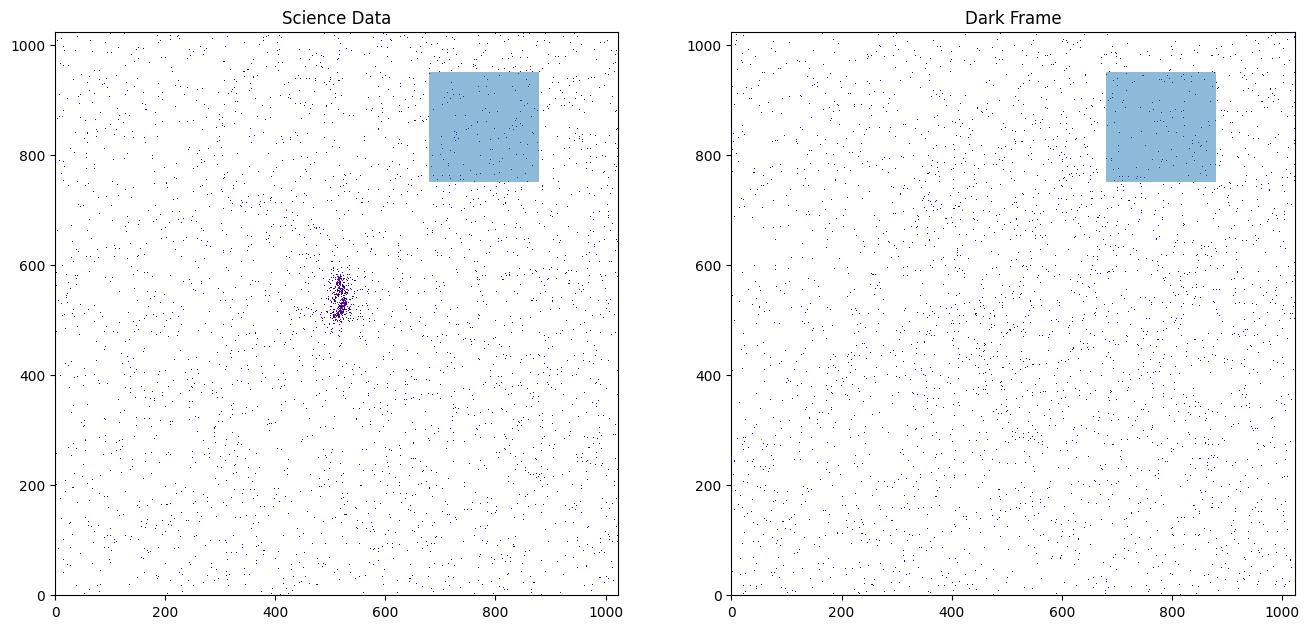

In [14]:
plt_kwargs = {'norm': LogNorm(),
              'interpolation': 'nearest',
              'cmap': 'plasma',
              'origin': 'lower'}

fig, ax = plt.subplots(1, 2, figsize=(16, 12))

science = fits.getdata('jcmc11ctq_flt.fits')
dark = fits.getdata('jcrx01iqq_raw.fits')

ax[0].set_title('Science Data')
ax[1].set_title('Dark Frame')

ax[0].imshow(science, **plt_kwargs)
ax[1].imshow(dark, **plt_kwargs)

# Must define twice since artist objects can only be used once.
patch0 = Rectangle((680, 750), width=200, height=200, alpha=0.5)
patch1 = Rectangle((680, 750), width=200, height=200, alpha=0.5)

ax[0].add_patch(patch0)
ax[1].add_patch(patch1)

To preserve important information in the header specific to the science image, such as the WCS solution, we will insert the data of the dark images into copies of the science images. We also must remember to adjust the exposure time of the copies of the science frames to that of the dark frames so that the drizzled products have the correct count rates.

In [15]:
flt_file = 'jcmc11ctq_flt.fits'
drk_file = 'jcrx01iiq_raw.fits'
new_file = 'dark1.fits'

os.system('cp {:} {:}'.format(flt_file, new_file))

darkdat = fits.getdata(drk_file)
exptime = fits.getval(drk_file, 'exptime', ext=0)

with fits.open(new_file, mode='update') as hdu:
    
    hdu[1].data[:, :] = darkdat
    hdu[0].header['exptime'] = exptime

In [16]:
flt_file = 'jcmc11e6q_flt.fits'
drk_file = 'jcrx01iyq_raw.fits'
new_file = 'dark2.fits'

os.system('cp {:} {:}'.format(flt_file, new_file))

darkdat = fits.getdata(drk_file)
exptime = fits.getval(drk_file, 'exptime', ext=0)

with fits.open(new_file, mode='update') as hdu:
    
    hdu[1].data[:, :] = darkdat
    hdu[0].header['exptime'] = exptime

We can now make the drizzled dark frame using the two individual dark frames we just made as inputs. The drizzle parameters are the same as the ones used to make the science drizzled products.

In [17]:
adriz_output = adriz(['dark1.fits', 'dark2.fits'], output='masterdark', **driz_kwargs)

No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 19:43:44.824 (14/08/2023)

==== Processing Step  Initialization  started at  19:43:44.825 (14/08/2023)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 165.55871248601244  38.04320516619231  
CRPIX : 707.5000105276703  686.0000102072953  
CD1_1 CD1_2  : -5.0808035164716374e-06  -4.733998760982597e-06  
CD2_1 CD2_2  : -4.733998760982597e-06  5.0808035164716374e-06  
NAXIS : 1416  1373
********************************************************************************
*
*  Estimated memory usage:  up to 30 Mb.
*  Output image size:       1416 X 1373 pixels. 
*  Output image file:       ~ 22 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 19:43:45.156 (14/08/2023)
==== Processing Step  Static Mask  started at  19:43:45.157 (14/08/2023)

==== Processi

We will now display the images to confirm that they show similar elevated dark rates. You might want do display them in DS9 (or any other viewer) outside of this notebook so you can play with the stretch a bit and so you can see bigger versions of the images.

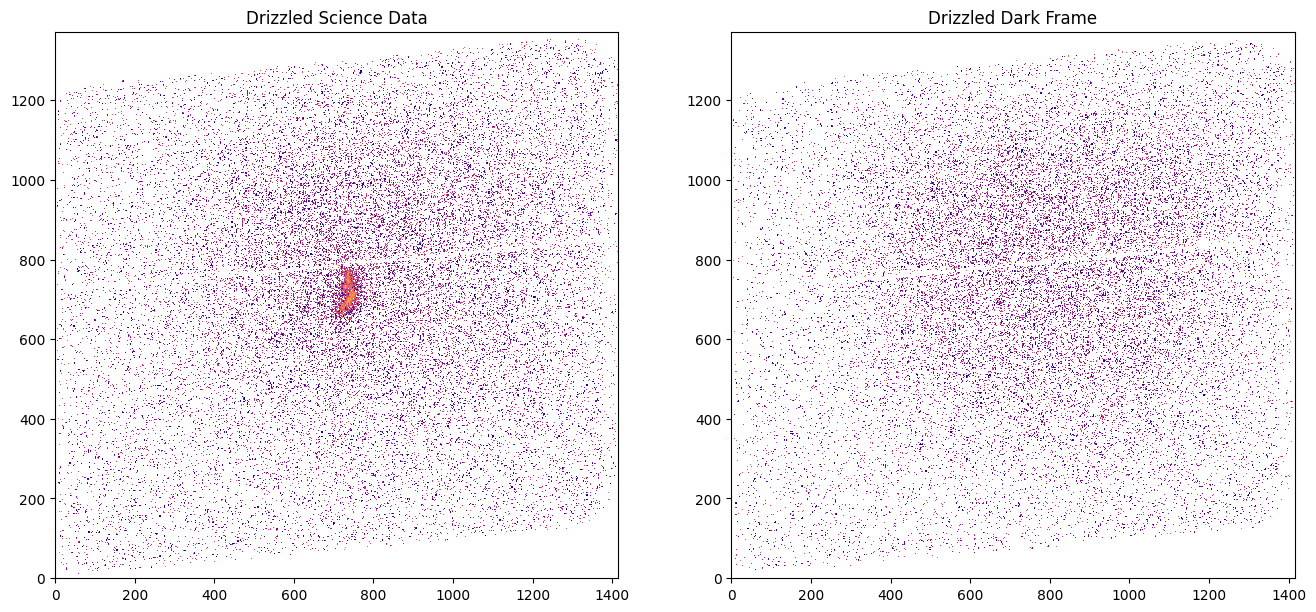

In [18]:
# Some plotting parameters
plt_kwargs = {'norm': LogNorm(vmin=1e-5, vmax=0.01),
              'interpolation': 'nearest',
              'cmap': 'plasma',
              'origin': 'lower'}

f165lp = fits.getdata('jcmc11010_drz_sci.fits')
masterdark = fits.getdata('masterdark_drz_sci.fits')

fig, ax = plt.subplots(1, 2, figsize=(16, 12))

ax[0].set_title('Drizzled Science Data')
ax[1].set_title('Drizzled Dark Frame')

ax[0].imshow(f165lp, **plt_kwargs)
ax[1].imshow(masterdark, **plt_kwargs)

The images look comparable. We will now proceed to performing some photometric analysis to estimate the dark current in the source.

## Photometry<a id="_photometry"></a>

***

Now we will use the `photutils` package to set up the two apertures. We will use these apertures to measure the flux of different regions in the images.

The first aperture is centered on our target at (735, 710), and is shaped as an elliptical to encompass all of the flux from the source. The other aperture will be the same exact shape, but located near the edge of the detector at (200, 200). 

In [19]:
aper = EllipticalAperture([(735, 710), (200, 200)], a=70, b=40, theta=0.5*np.pi)

Let's overplot the two apertures in the images so you can see their locations.

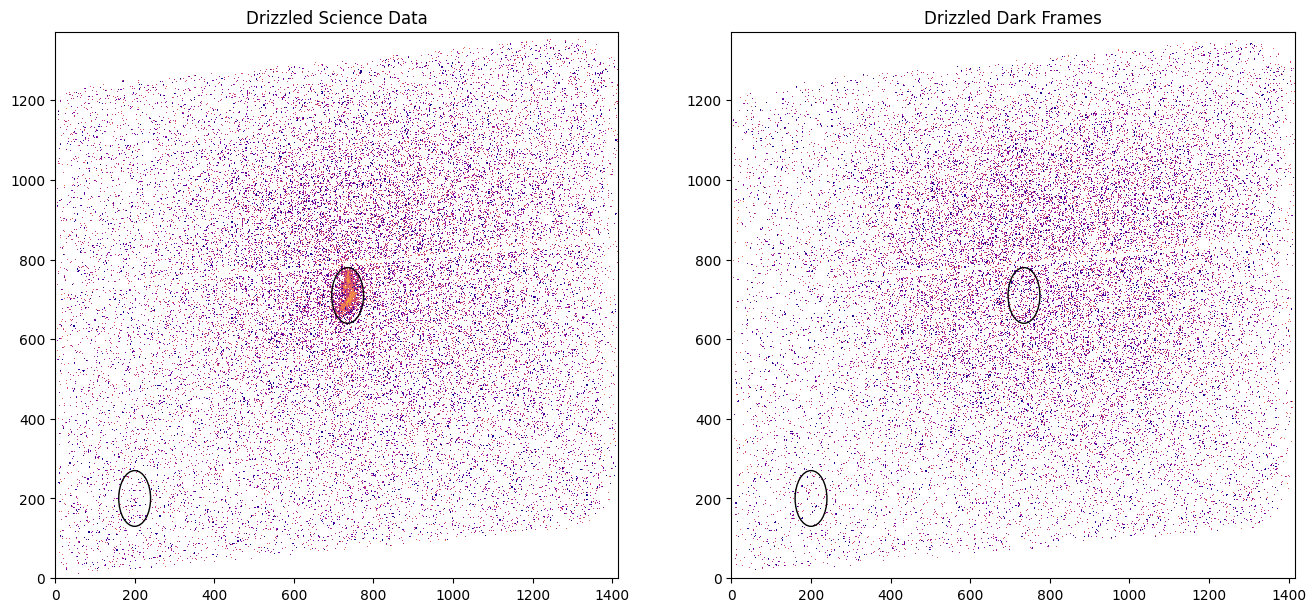

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))

ax[0].set_title('Drizzled Science Data')
ax[1].set_title('Drizzled Dark Frames')

ax[0].imshow(f165lp, **plt_kwargs)
ax[1].imshow(masterdark, **plt_kwargs)

aper.plot(ax[0])
aper.plot(ax[1])

Finally, we do the photometry using the two apertures on both images. We print out the tables to see the results.

In [21]:
f165lp_phot = aperture_photometry(f165lp, aper)
masterdark_phot = aperture_photometry(masterdark, aper)

sumdiff = f165lp_phot['aperture_sum'] - masterdark_phot['aperture_sum']

print('Science data photometry:\n')
print(f165lp_phot)
print('\n')

print('Dark frame photometry:\n')
print(masterdark_phot)
print('\n')

print('\nDifference of aperture sums (science - dark):\n')
print(sumdiff)

Science data photometry:

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   735.0   710.0  2.8856736724958347
  2   200.0   200.0 0.09034156487303398


Dark frame photometry:

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   735.0   710.0  0.3220899594961391
  2   200.0   200.0 0.06845012812778462



Difference of aperture sums (science - dark):

    aperture_sum    
--------------------
  2.5635837129996957
0.021891436745249362


The target aperture has 2.89 cts/sec, while the same aperture in the dark frame has 0.322 cts/sec. That means that ~11% of the flux in your source comes from dark current and should be subtracted out, leaving a flux for you source of 2.564 cts/sec. 

## Final Thoughts

***

1. The difference in flux in the second aperture (the one in the lower left portion of the image) shows that there is a small residual background of ~0.02 cts/sec in the science frame. This could be real background from the sky (and not dark current from the detector that you might want to account for properly in your flux and error budget.

2. The dark frame we created does not have the exact same dark count rate as we measured in the science frame. You could try searching for other darks that more closely resemble your science frame. 

3. These problems can be avoided using a few strategies detailed in [ISR ACS 2018-07](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr1807.pdf) (Avila 2018).

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.